<a href="https://colab.research.google.com/github/ducanhho2296/unconditional-GAN/blob/main/Unconditional_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LOADING MNIST DATASET

In [45]:
from keras.datasets.fashion_mnist import load_data
import matplotlib.pyplot as plt
from numpy import expand_dims, zeros, ones
from numpy.random import randn, randint
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

#load images into memory
(trainX, trainy), (testX, testy) = load_data()

#print summarize the shape of inputs and labels
print("Train", trainX.shape, trainy.shape)
print("Test", testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


##plot dataset

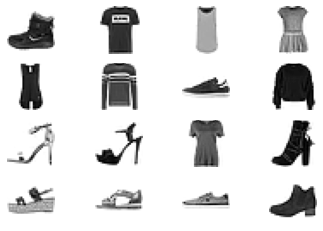

In [46]:
#plot raw pixel data
for i in range(16):
  plt.subplot(4, 4, 1+i)
  #turn off axis
  plt.axis('off')
  #show raw pixel data
  plt.imshow(trainX[i], cmap='gray_r')
plt.show()

#Build Unconditional GANs


##Build Discriminator

In [47]:
def define_discriminator(in_shape=(28,28,1)): #input.shape = (28,28,1)
  model = Sequential()
  #perform downsampling
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  #dowmsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  #optimizing with adam
  opt = Adam(lr=0.0002, beta_1=0.5)
  #complile model
  model.compile(loss='binary_crossentropy', optimizer=opt,
                metrics=['accuracy'])
  return model

##Build Generator

In [48]:
def define_generator(latent_dim):
  model = Sequential()
  # foundation for 7x7 image
  n_nodes = 128 * 7 * 7
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7, 7, 128)))
  # upsample to 14x14
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 28x28
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # generate
  model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
  return model

##Build larger model
##### large model contains discriminator and Generator, which will be used to train the model weights in generator and feed output into discriminator to calculate error.

In [49]:
def define_gan(generator, discriminator):
  # shutdown training of discriminator 
  discriminator.trainable = False
  model = Sequential()
  #add generator
  model.add(generator)
  #add discriminator
  model.add(discriminator)
  #optimize model
  opt = Adam(lr=0.0002, beta_1=0.5)

  #compile model
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model


#Time to train model

##Loading dataset

In [50]:
def load_real_samples():
  #load dataset
  (trainX, _), (_, _)  = load_data()
  #expand to 3d by adding channel
  X = expand_dims(trainX, axis=-1)
  #convert ints to floats
  X = X.astype('float32')
  #scale from [0,255] to [-1, 1]
  X = X / 255
  return X

###pickup random sample for generator
(one batch)

In [51]:
def generate_real_samples(dataset, n_samples):
  #random instances
  ix = randint(0, dataset.shape[0], n_samples)
  #select images
  X = dataset[ix]
  #generate class labels
  #labels must 1 because generator want to fool discriminator
  y = ones((n_samples, 1))
  return X, y

####Generate random noise with Gaussian distributed

In [52]:
def generate_latent_points(latent_dim, n_samples):
  x_input = randn(latent_dim * n_samples)
  #reshape into inputs
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

###Generate fake examples

In [56]:
def generate_fake_samples(generator, latent_dim, n_samples):
  x_input = generate_latent_points(latent_dim, n_samples)
  #predict output
  X = generator.predict(x_input)
  #create class labels 0 for discriminator
  y = zeros((n_samples, 1))
  return X, y

##Fiting model
### model will be trained:
*   100 epochs
*   batchsize = 128 examples
*   batchs each epochs = 60000/128 = 468 batches 






In [59]:
def train(g_model, d_model, gan_model, dataset,
          latent_dim, n_epochs=100,
          n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  #enumerate epochs
  for i in range(n_epochs):
    #loop over training set
    for j in range(bat_per_epo):
      #generate randomly "real" samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      #update discriminator model weights
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)

      #generate "fake" samples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      #update dis. model weights
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
      
      #add noise 
      X_gan = generate_latent_points(latent_dim, n_batch)
      #create true label for fake samples
      y_gan = ones((n_batch, 1))
      #### update generator weights via dis. erro #####
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      #summarize loss
      print('>>%d, %d/%d, d1=%.3f, d2=%.3f, g=%3f' %
            (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

  #save generator
  g_model.save('generator.h5')

In [58]:
latent_dim = 100
#create models
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
#load image data
dataset = load_real_samples()
#train model
train(generator, discriminator, gan_model, dataset, latent_dim)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>>1, 1/468, d1=0.699, d2=0.694, g=0.692946
>>1, 2/468, d1=0.648, d2=0.697, g=0.689464
>>1, 3/468, d1=0.606, d2=0.709, g=0.677645
>>1, 4/468, d1=0.575, d2=0.732, g=0.656783
>>1, 5/468, d1=0.536, d2=0.767, g=0.627140
>>1, 6/468, d1=0.518, d2=0.819, g=0.590216
>>1, 7/468, d1=0.503, d2=0.884, g=0.552786
>>1, 8/468, d1=0.487, d2=0.944, g=0.522914
>>1, 9/468, d1=0.511, d2=0.983, g=0.517808
>>1, 10/468, d1=0.522, d2=0.965, g=0.538496
>>1, 11/468, d1=0.552, d2=0.892, g=0.582075
>>1, 12/468, d1=0.585, d2=0.805, g=0.652816
>>1, 13/468, d1=0.605, d2=0.733, g=0.719286
>>1, 14/468, d1=0.618, d2=0.656, g=0.789081
>>1, 15/468, d1=0.638, d2=0.612, g=0.838166
>>1, 16/468, d1=0.641, d2=0.575, g=0.886914
>>1, 17/468, d1=0.658, d2=0.561, g=0.895382
>>1, 18/468, d1=0.670, d2=0.569, g=0.861235
>>1, 19/468, d1=0.682, d2=0.599, g=0.816997
>>1, 20/468, d1=0.665, d2=0.632, g=0.778558
>>1, 21/468, d1=0.655, d2=0.668, g=0.731778
>>1, 22/468, d1=0.628, d2=0.695, g=0.700176
>>1, 23/468, d1=0.590, d2=0.709, g=0.6892

KeyboardInterrupt: ignored